In [1]:
# XO's note on 02/08/2022: This is a quick check on the error distribution of the all the computed kinematic parameters
# and orbital parameters for my sample

In [2]:
# Import the libraries
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap, Normalize, LogNorm
from scipy.interpolate import interpn
import seaborn as sns

cmap = ListedColormap(sns.color_palette("colorblind",256))
pal = sns.color_palette('colorblind', 256)

# import astropy.coordinates as coord
# import astropy.units as u

label_size = 24
matplotlib.rc('font', size=label_size) 

import warnings
warnings.filterwarnings("once")

In [3]:
# Import the data
df_vel_all = pd.read_hdf('../data/dr3_near_vel_plxzp_g2_only.h5')
df_orb_all = pd.read_hdf('../data/dr3_orb_param_err_g2_only.h5')

/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
# calculate the columns for the scaled action diamond
df_orb_all['Jtot'] = np.sqrt(df_orb_all['Jphi']**2+df_orb_all['JR']**2+df_orb_all['Jz']**2)
df_orb_all['diamond_x']=df_orb_all['Jphi']/df_orb_all['Jtot']
df_orb_all['diamond_y']=(df_orb_all['Jz']-df_orb_all['JR'])/df_orb_all['Jtot']

# Calculate the error for Jtot and diamond_x/y
df_orb_all['e_Jtot'] = np.sqrt(df_orb_all['Jphi']**2*df_orb_all['e_Jphi']**2+df_orb_all['JR']**2*df_orb_all['e_JR']**2+df_orb_all['Jz']**2*df_orb_all['e_Jz']**2)/df_orb_all['Jtot']
df_orb_all['e_diamond_x']=np.sqrt(df_orb_all['Jtot']**2*df_orb_all['e_Jphi']**2+df_orb_all['e_Jtot']**2*df_orb_all['Jphi']**2)/df_orb_all['Jtot']**2
df_orb_all['e_diamond_y']=np.sqrt(df_orb_all['Jtot']**2*(df_orb_all['e_JR']**2+df_orb_all['e_Jz']**2)+df_orb_all['e_Jtot']**2*(df_orb_all['Jz']-df_orb_all['JR'])**2)/df_orb_all['Jtot']**2

# Calculate L_perp for clustering
df_orb_all['Lperp'] = np.sqrt(df_orb_all['Lx']**2+df_orb_all['Ly']**2)
df_orb_all['e_Lperp'] = np.sqrt(df_orb_all['Lx']**2*df_orb_all['e_Lx']**2+df_orb_all['Ly']**2*df_orb_all['e_Ly']**2)/df_orb_all['Lperp']

In [5]:
print(df_vel_all.columns,df_orb_all.columns)

Index(['index', 'source_id', 'ra', 'dec', 'm_h_ap', 'm_h_err_ap', 'm_h_flg_ap',
       'alpha_m_ap', 'alpha_m_err_ap', 'alpha_m_flg_ap', 'm_h_l6s',
       'm_h_err_l6s', 'm_h_flg_l6s', 'alpha_m_l6s', 'alpha_m_err_l6s',
       'alpha_m_flg_l6s', 'm_h_gl3', 'm_h_err_gl3', 'm_h_flg_gl3',
       'alpha_m_gl3', 'alpha_m_err_gl3', 'alpha_m_flg_gl3', 'm_h_r6',
       'alpha_m_r6', 'm_h_err_r6', 'alpha_m_err_r6', 'XGC', 'YGC', 'ZGC',
       'm_h_r6c', 'alpha_m_r6c', 'm_h_err_r6c', 'alpha_m_err_r6c',
       'm_h_flg_r6c', 'alpha_m_flg_r6c', 'qual_flag', 'bin_flag', 'parallax',
       'parallax_error', 'parallax_zpcorr', 'l', 'b', 'XGCerr', 'YGCerr',
       'ZGCerr', 'U_g2', 'Uerr_g2', 'V_g2', 'Verr_g2', 'W_g2', 'Werr_g2',
       'UVcov_g2', 'UWcov_g2', 'VWcov_g2', 'v_forder_g2', 'vr_g2', 'vphi_g2',
       'vz_g2', 'vrerr_g2', 'vphierr_g2', 'vzerr_g2', 'vrphicov_g2',
       'vrzcov_g2', 'vphizcov_g2', 'm_h_ap17', 'm_h_err_ap17', 'alpha_m_ap17',
       'alpha_m_err_ap17', 'aspcap_flg_ap17'],
    

In [6]:
# Write a general function for plotting histogram to examine the distribution
def plot_dist(data_list,label_list,xlabel='',xrange=[],ylog=False,fname=None,**kwargs):
    f = plt.figure(figsize=[10,8])
    
    for i in range(len(data_list)):
        sns.distplot(data_list[i],label=label_list[i],**kwargs)

    plt.legend(fontsize='small')
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    if len(xrange) != 0:
        plt.xlim(xrange)
    if ylog:
        plt.yscale('log')
    plt.show()
    
    if fname != None:
        f.savefig(fname,layout='tight')

In [7]:
# Define what axes go into PCA
action = True
diamond = False
metallicity = False
velocity = False
cylindrical = True
position = False
energy = True
eccentricity = False
Lz = False
Lperp = False

# Define what axes go into GMM with PCA results
# By default, include whatever was not in PCA
action_add = not action
metallicity_add = not metallicity
velocity_add = not velocity
position_add = not position
energy_add = not energy
eccentricity_add = not eccentricity
Lz_add = not Lz
Lperp_add = not Lperp

# Manual override additional axes
action_add = False
position_add = False
metallicity_add = False
velocity_add = False
energy_add = False
eccentricity_add = False
Lz_add = False
Lperp_add = False

In [12]:
cutoff = 3500
kin_qual = ((abs(df_vel_all['U_g2']) < 1000) & 
            (abs(df_vel_all['V_g2']) < 1000) & (abs(df_vel_all['W_g2']) < 1000) & 
            (df_vel_all['qual_flag'] == 0) # & 
           )
selection = ((df_orb_all['zmax']-2*df_orb_all['e_zmax']) > cutoff)

# Quickly print the sample size without error cut
combined_cut_pre_err = kin_qual & selection


# Add in an additional relative error cut on the input parameters; ignore it if the value is greater than 99
error_cut = np.copy(kin_qual)
rel_err_cutoff = 0.05
# Set a flag to decide if we want to apply an absolute cut when available
error_cut_rel_flag = False

if rel_err_cutoff < 99:
    if action == True or action_add == True:
        if diamond == True:
            error_cut = error_cut & (abs(df_orb_all['e_diamond_x']/df_orb_all['diamond_x']) < rel_err_cutoff)
            error_cut = error_cut & (abs(df_orb_all['e_diamond_y']/df_orb_all['diamond_y']) < rel_err_cutoff)
        elif diamond == False:
            if error_cut_rel_flag:
                error_cut = error_cut & (abs(df_orb_all['e_JR']/df_orb_all['JR']) < rel_err_cutoff)
                error_cut = error_cut & (abs(df_orb_all['e_Jphi']/df_orb_all['Jphi']) < rel_err_cutoff)
                error_cut = error_cut & (abs(df_orb_all['e_Jz']/df_orb_all['Jz']) < rel_err_cutoff)
            else:
                error_cut = error_cut & (df_orb_all['e_JR'] < 150)
                error_cut = error_cut & (df_orb_all['e_Jphi'] < 100)
                error_cut = error_cut & (df_orb_all['e_Jz'] < 100)

    if metallicity == True or metallicity_add == True:
        feh_qual = feh_qual & (abs(df_vel_all['e_m_h_mean']/df_vel_all['m_h_mean']) < rel_err_cutoff)

    if velocity == True or velocity_add == True:
        if cylindrical == True:
            if error_cut_rel_flag:
                error_cut = error_cut & (abs(df_vel_all['vrerr_g2']/df_vel_all['vr_g2']) < rel_err_cutoff)
                error_cut = error_cut & (abs(df_vel_all['vphierr_g2']/df_vel_all['vphi_g2']) < rel_err_cutoff)
                error_cut = error_cut & (abs(df_vel_all['vzerr_g2']/df_vel_all['vz_g2']) < rel_err_cutoff)
            else:
                error_cut = error_cut & (df_vel_all['vrerr_g2'] < 20)
                error_cut = error_cut & (df_vel_all['vphierr_g2'] < 20)
                error_cut = error_cut & (df_vel_all['vzerr_g2'] < 20)
        elif cylindrical == False:
            error_cut = error_cut & (abs(df_vel_all['Uerr_g2']/df_vel_all['U_g2']) < rel_err_cutoff)
            error_cut = error_cut & (abs(df_vel_all['Verr_g2']/df_vel_all['V_g2']) < rel_err_cutoff)
            error_cut = error_cut & (abs(df_vel_all['Werr_g2']/df_vel_all['W_g2']) < rel_err_cutoff)

    if position == True or position_add == True:
        error_cut = error_cut & (abs(df_vel_all['XGCerr']/df_vel_all['XGC']) < rel_err_cutoff)
        error_cut = error_cut & (abs(df_vel_all['YGCerr']/df_vel_all['YGC']) < rel_err_cutoff)
        error_cut = error_cut & (abs(df_vel_all['ZGCerr']/df_vel_all['ZGC']) < rel_err_cutoff)

    if energy == True or energy_add == True:
        if error_cut_rel_flag:
            error_cut = error_cut & (abs(df_orb_all['e_Etot']/df_orb_all['Etot']) < rel_err_cutoff)
        else:
            error_cut = error_cut & (df_orb_all['e_Etot'] < 4000)

    if eccentricity == True or eccentricity_add == True:
        error_cut = error_cut & (abs(df_orb_all['e_ecc']/df_orb_all['ecc']) < rel_err_cutoff)

    if Lz == True or Lz_add == True:
        if error_cut_rel_flag:
            error_cut = error_cut & (abs(df_orb_all['e_Lz']/df_orb_all['Lz']) < rel_err_cutoff)
        else:
            error_cut = error_cut & (df_orb_all['e_Lz'] < 100)

    if Lperp == True or Lperp_add == True:
        if error_cut_rel_flag:
            error_cut = error_cut & (abs(df_orb_all['e_Lperp']/df_orb_all['Lperp']) < rel_err_cutoff)
        else:
            error_cut = error_cut & (df_orb_all['e_Lperp'] < 100)

# Put all cuts together
combined_cut = kin_qual & selection & error_cut

# Print the sample sizes at different cut
ind_cut_pre_err_zmax = np.where(kin_qual)[0]
print('Sample size with quality cut:',len(ind_cut_pre_err_zmax))

ind_cut_pre_err = np.where(combined_cut_pre_err)[0]
print('Sample size with quality and zmax cut:',len(ind_cut_pre_err))

ind_cut = np.where(combined_cut)[0]
print('Sample size with quality, zmax, and relative error cut:',len(ind_cut))

Sample size with quality cut: 5557670
Sample size with quality and zmax cut: 8166
Sample size with quality, zmax, and relative error cut: 6552


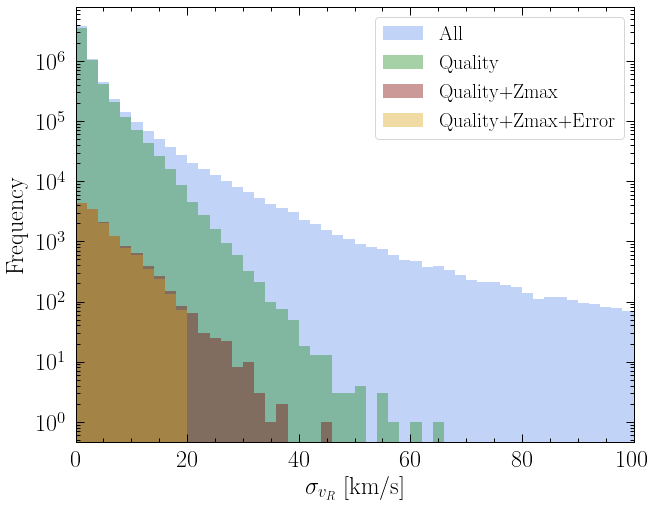

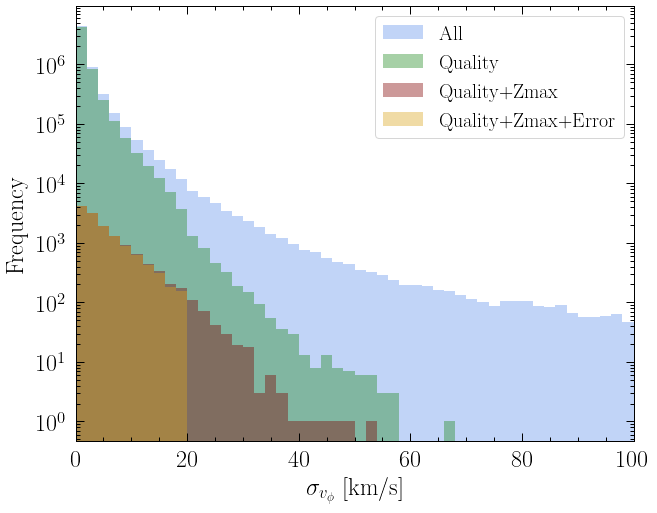

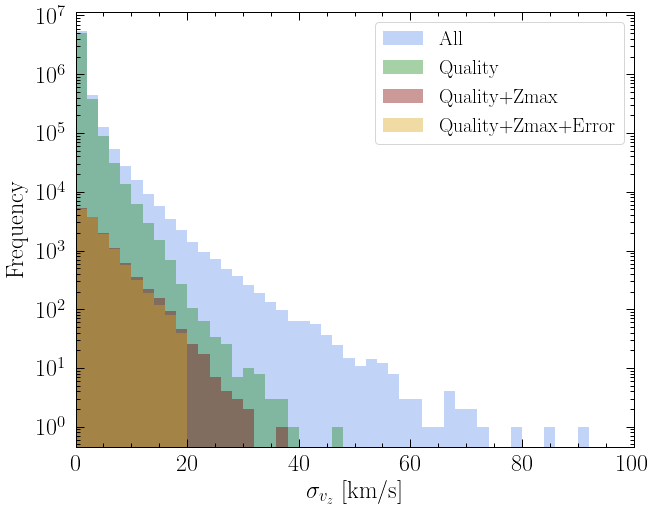

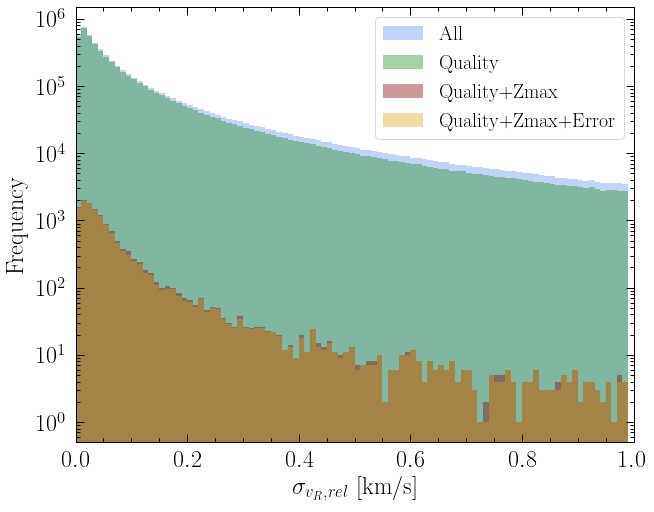

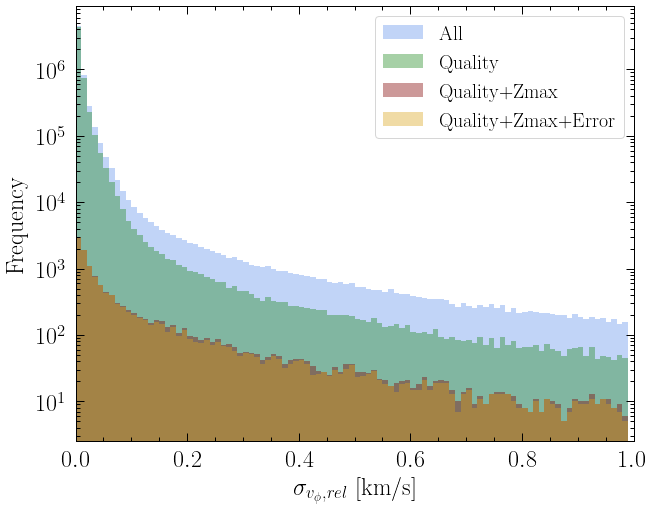

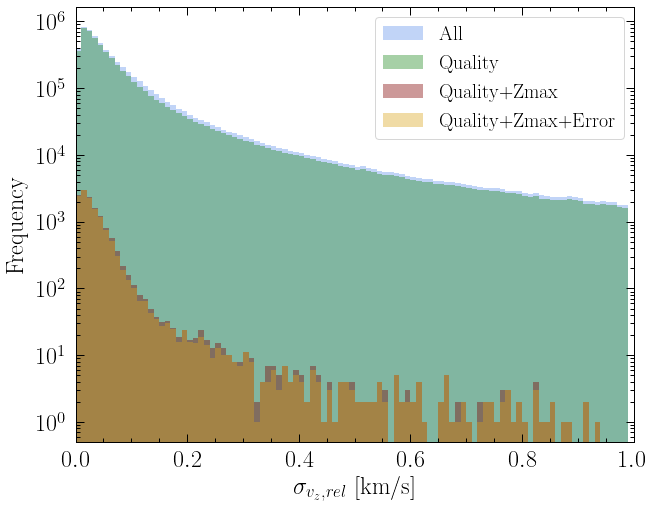

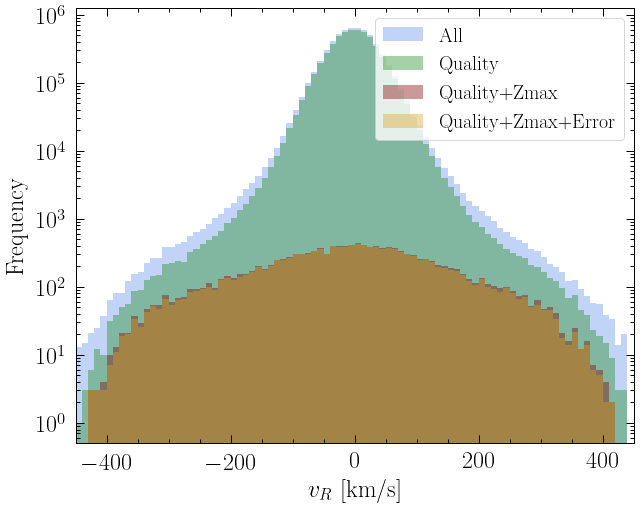

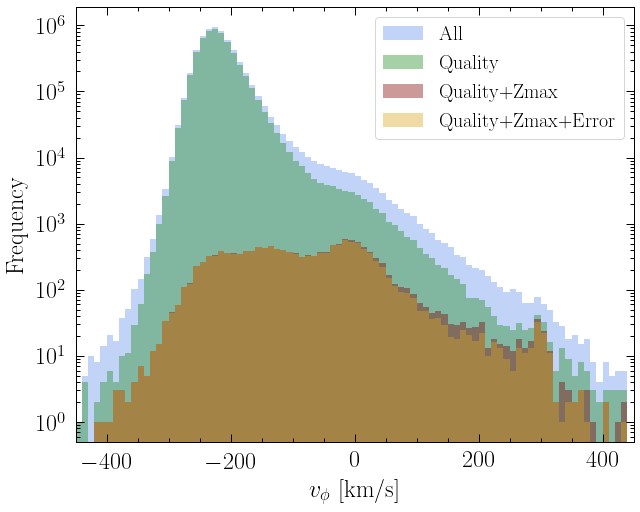

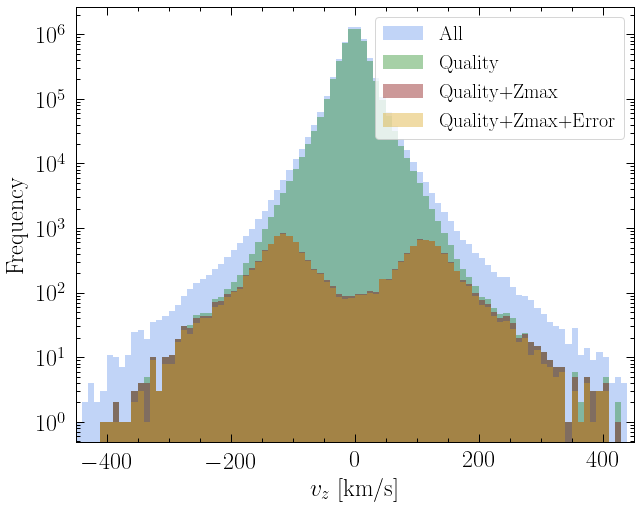

In [98]:
dir_plot = './velocities_abs_err_cut/zmax_'+str(cutoff)+'_'
col_to_plot = ['vrerr_g2','vphierr_g2', 'vzerr_g2']
rel_col_to_plot = ['vr_g2','vphi_g2', 'vz_g2']
axis_labels = [r'$\sigma_{v_{R}}$ [km/s]',r'$\sigma_{v_{\phi}}$ [km/s]',r'$\sigma_{v_{z}}$ [km/s]']
# Plot the absolute error distribution
for col, axis_label in zip(col_to_plot,axis_labels):
    plot_dist(data_list=[df_vel_all.loc[:,col],df_vel_all.loc[ind_cut_pre_err_zmax,col],df_vel_all.loc[ind_cut_pre_err,col],df_vel_all.loc[ind_cut,col]],
              label_list=['All','Quality','Quality+Zmax','Quality+Zmax+Error'],xlabel=axis_label,xrange=[0,100],ylog=True,
              hist=True,kde=False,bins=np.arange(0,102,2),fname=dir_plot+col+'_dist.pdf')
# Plot the relative error distribution
axis_labels = [r'$\sigma_{v_{R},rel}$ [km/s]',r'$\sigma_{v_{\phi},rel}$ [km/s]',r'$\sigma_{v_{z},rel}$ [km/s]']
for col, rel_col, axis_label in zip(col_to_plot,rel_col_to_plot,axis_labels):
    plot_dist(data_list=[abs(df_vel_all.loc[:,col]/df_vel_all.loc[:,rel_col]),
                         abs(df_vel_all.loc[ind_cut_pre_err_zmax,col]/df_vel_all.loc[ind_cut_pre_err_zmax,rel_col]),
                         abs(df_vel_all.loc[ind_cut_pre_err,col]/df_vel_all.loc[ind_cut_pre_err,rel_col]),
                         abs(df_vel_all.loc[ind_cut,col]/df_vel_all.loc[ind_cut,rel_col])],
              label_list=['All','Quality','Quality+Zmax','Quality+Zmax+Error'],xlabel=axis_label,xrange=[0,1],ylog=True,
              hist=True,kde=False,bins=np.arange(0,1,0.01),fname=dir_plot+col+'_rel_dist.pdf')
# Plot how the original inputs distribution changes as we make the cuts
col_to_plot = ['vr_g2','vphi_g2', 'vz_g2']
axis_labels = [r'$v_{R}$ [km/s]',r'$v_{\phi}$ [km/s]',r'$v_{z}$ [km/s]']
for col, axis_label in zip(col_to_plot,axis_labels):
    plot_dist(data_list=[df_vel_all.loc[:,col],df_vel_all.loc[ind_cut_pre_err_zmax,col],df_vel_all.loc[ind_cut_pre_err,col],df_vel_all.loc[ind_cut,col]],
              label_list=['All','Quality','Quality+Zmax','Quality+Zmax+Error'],xlabel=axis_label,xrange=[-450,450],ylog=True,
              hist=True,kde=False,bins=np.arange(-450,450,10),fname=dir_plot+col+'_dist.pdf')

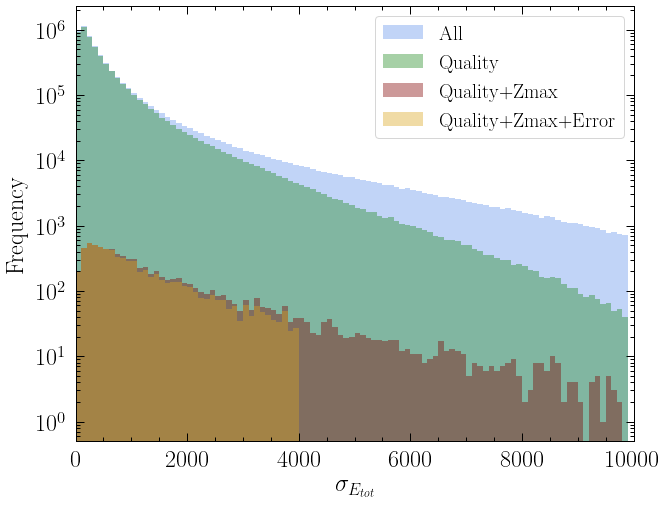

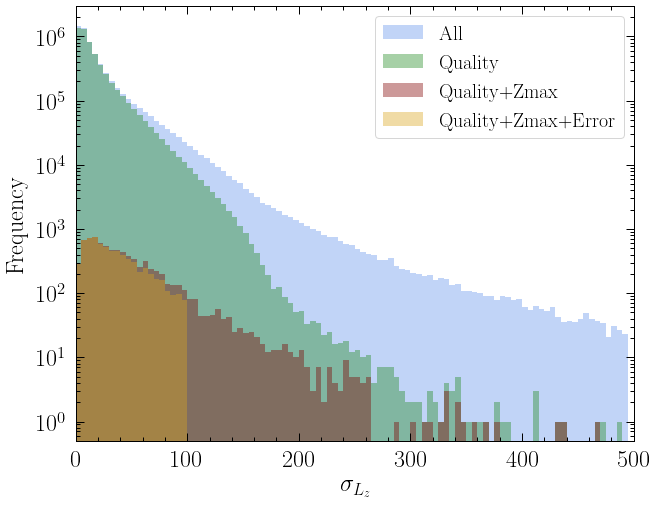

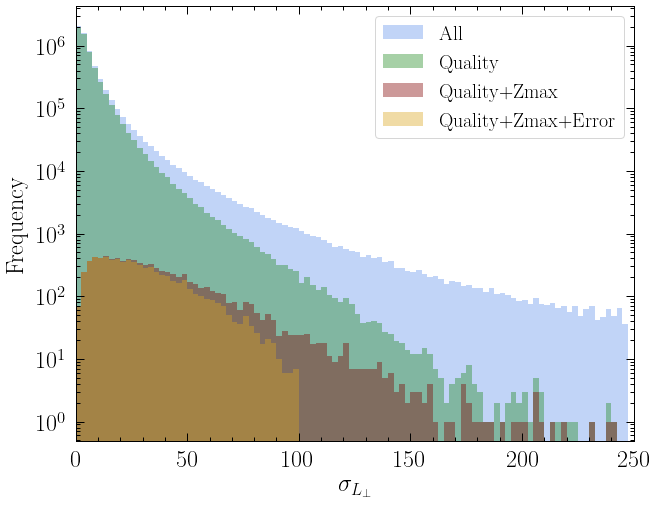

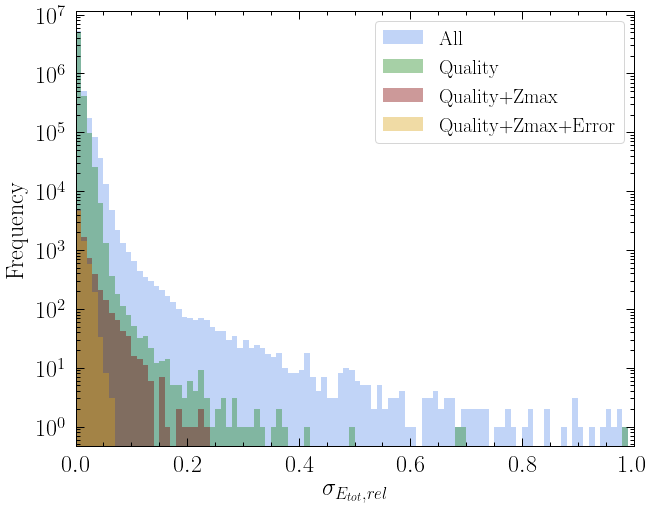

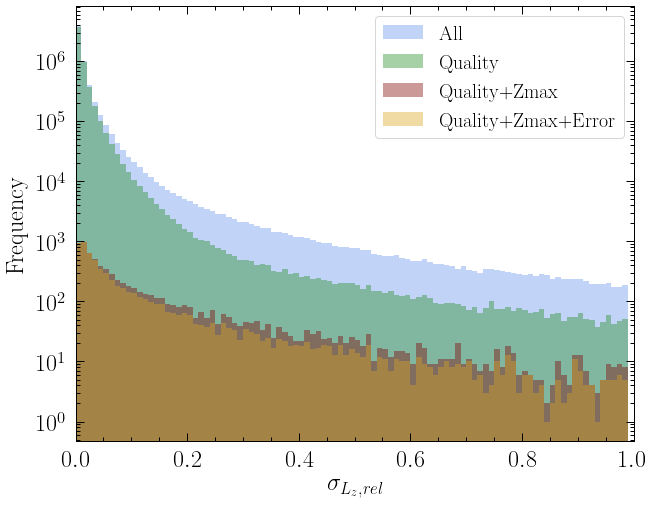

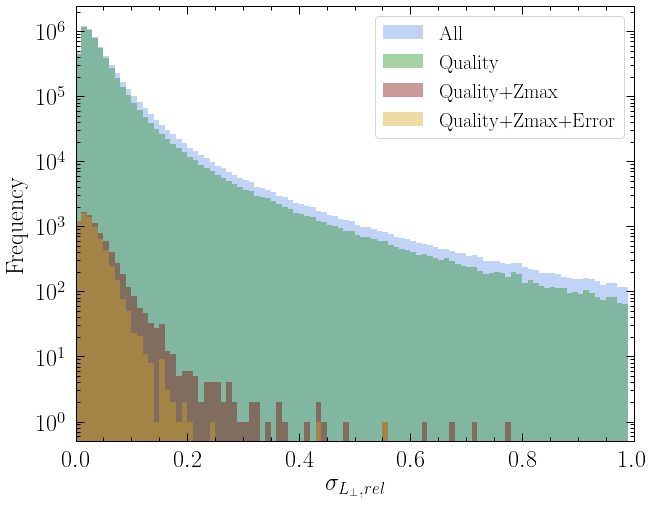

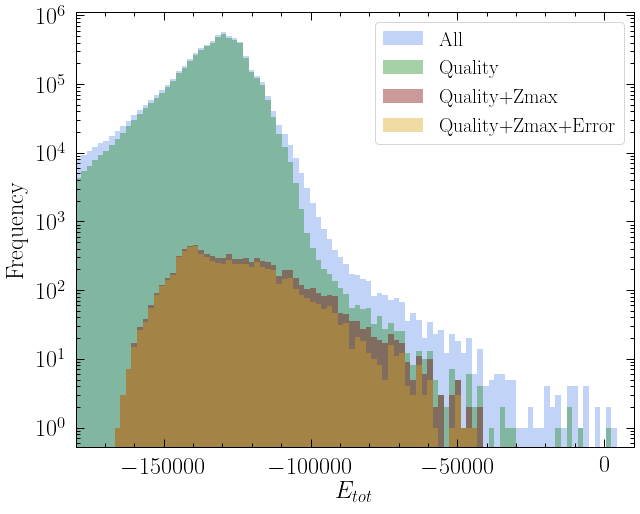

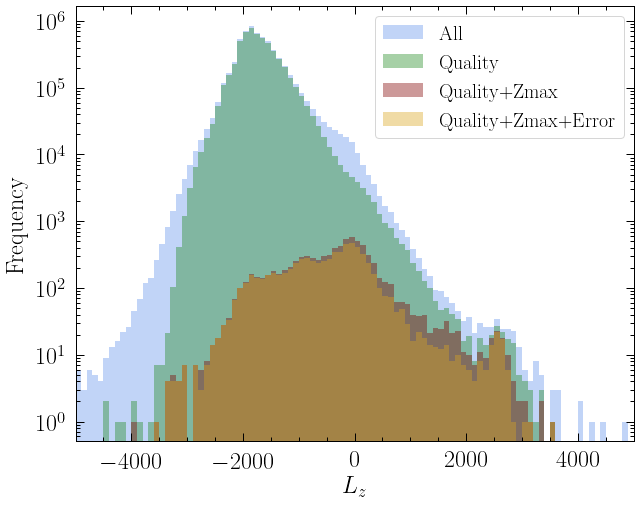

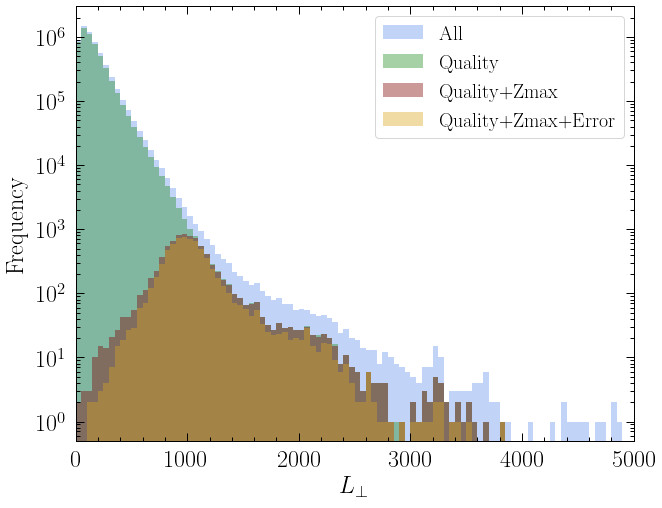

In [113]:
# Make sure the cuts are properly applied before running this script!
dir_plot = './energy_angmom_abs_err_cut/zmax_'+str(cutoff)+'_'
col_to_plot = ['e_Etot','e_Lz','e_Lperp']
rel_col_to_plot = ['Etot','Lz','Lperp']
axis_labels = [r'$\sigma_{E_{tot}}$',r'$\sigma_{L_{z}}$',r'$\sigma_{L_{\bot}}$']
xrange_list = [[0,10000],[0,500],[0,250]]
xbins_list = [np.arange(0,10000,100),np.arange(0,500,5),np.arange(0,250,2.5)]
# Plot the absolute error distribution
for col, axis_label, xrange, xbins in zip(col_to_plot,axis_labels,xrange_list,xbins_list):
    plot_dist(data_list=[df_orb_all.loc[:,col],df_orb_all.loc[ind_cut_pre_err_zmax,col],df_orb_all.loc[ind_cut_pre_err,col],df_orb_all.loc[ind_cut,col]],
              label_list=['All','Quality','Quality+Zmax','Quality+Zmax+Error'],xlabel=axis_label,xrange=xrange,ylog=True,
              hist=True,kde=False,bins=xbins,fname=dir_plot+col+'_dist.pdf')
# Plot the relative error distribution
axis_labels = [r'$\sigma_{E_{tot},rel}$',r'$\sigma_{L_{z},rel}$',r'$\sigma_{L_{\bot},rel}$']
for col, rel_col, axis_label in zip(col_to_plot,rel_col_to_plot,axis_labels):
    plot_dist(data_list=[abs(df_orb_all.loc[:,col]/df_orb_all.loc[:,rel_col]),
                         abs(df_orb_all.loc[ind_cut_pre_err_zmax,col]/df_orb_all.loc[ind_cut_pre_err_zmax,rel_col]),
                         abs(df_orb_all.loc[ind_cut_pre_err,col]/df_orb_all.loc[ind_cut_pre_err,rel_col]),
                         abs(df_orb_all.loc[ind_cut,col]/df_orb_all.loc[ind_cut,rel_col])],
              label_list=['All','Quality','Quality+Zmax','Quality+Zmax+Error'],xlabel=axis_label,xrange=[0,1],ylog=True,
              hist=True,kde=False,bins=np.arange(0,1,0.01),fname=dir_plot+col+'_rel_dist.pdf')
# Plot how the original inputs distribution changes as we make the cuts
col_to_plot = ['Etot','Lz','Lperp']
axis_labels = [r'$E_{tot}$',r'$L_{z}$',r'$L_{\bot}$']
xrange_list = [[-180000,10000],[-5000,5000],[0,5000]]
xbins_list = [np.arange(-180000,10000,1900),np.arange(-5000,5000,100),np.arange(0,5000,50)]
for col, axis_label, xrange, xbins in zip(col_to_plot,axis_labels,xrange_list,xbins_list):
    plot_dist(data_list=[df_orb_all.loc[:,col],df_orb_all.loc[ind_cut_pre_err_zmax,col],df_orb_all.loc[ind_cut_pre_err,col],df_orb_all.loc[ind_cut,col]],
              label_list=['All','Quality','Quality+Zmax','Quality+Zmax+Error'],xlabel=axis_label,xrange=xrange,ylog=True,
              hist=True,kde=False,bins=xbins,fname=dir_plot+col+'_dist.pdf')

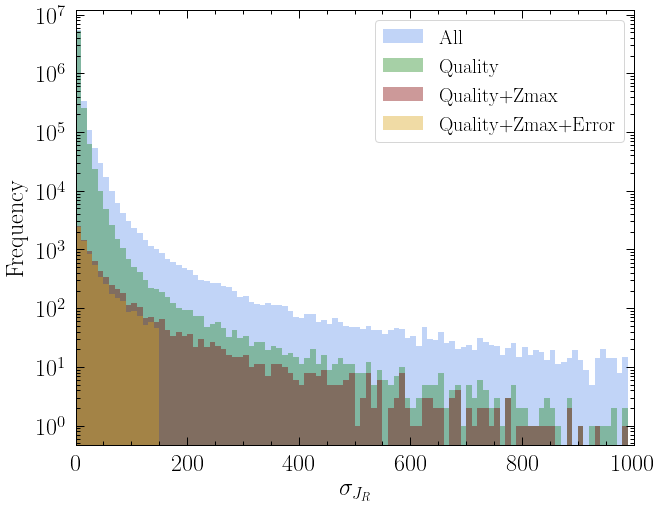

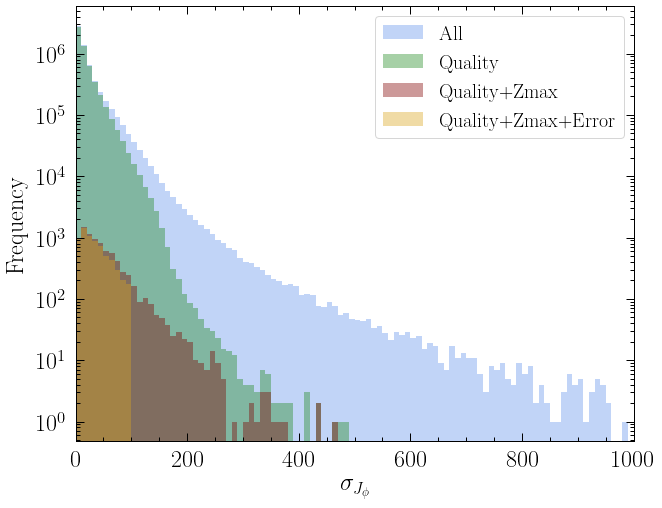

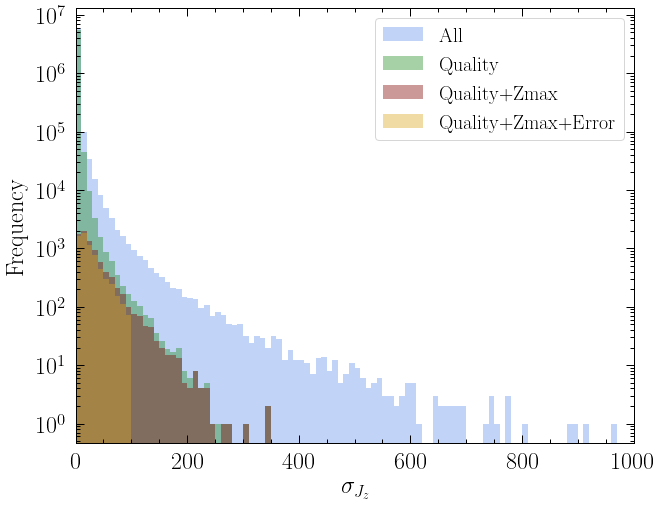

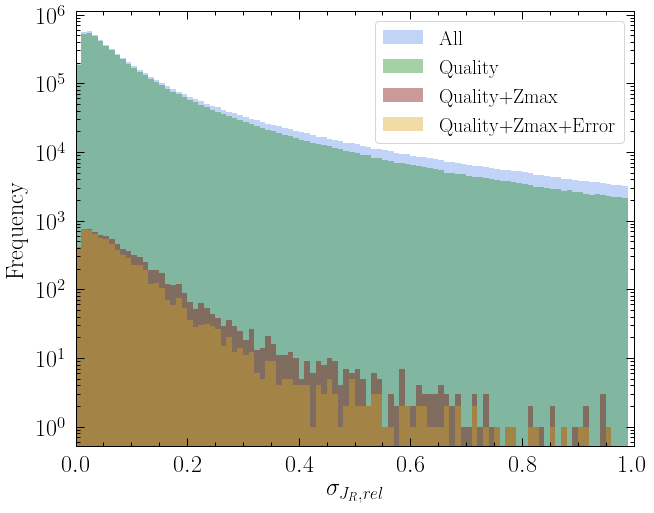

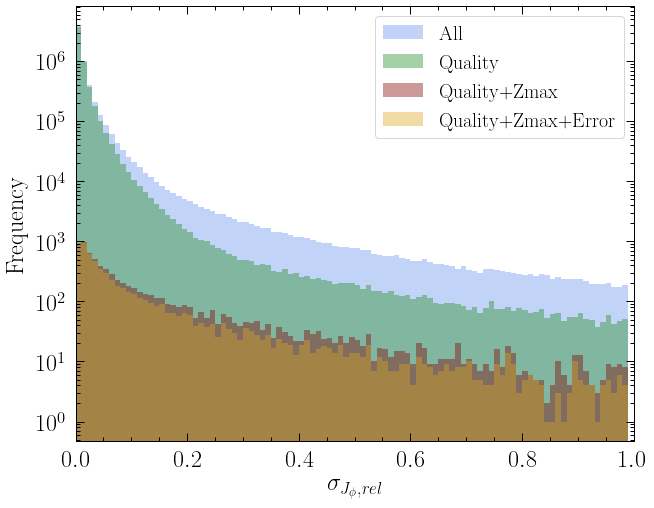

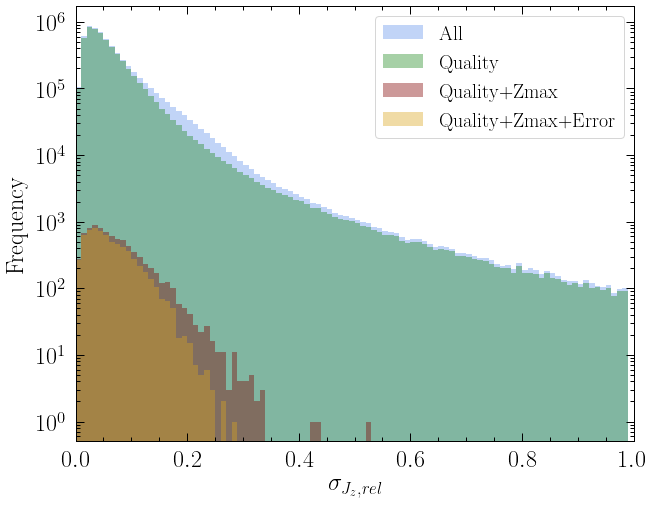

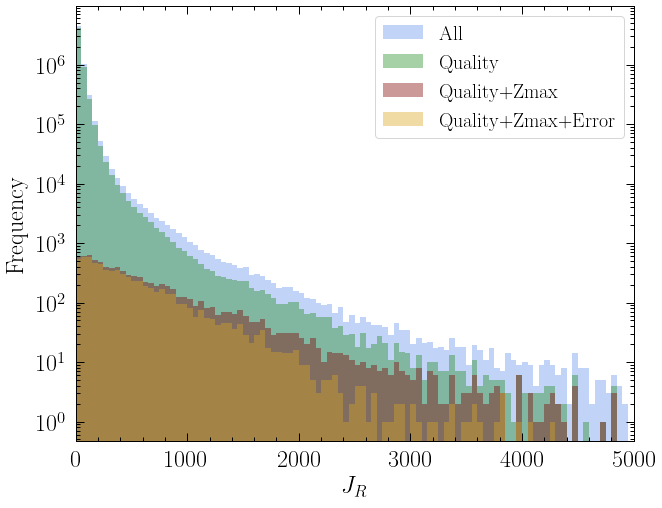

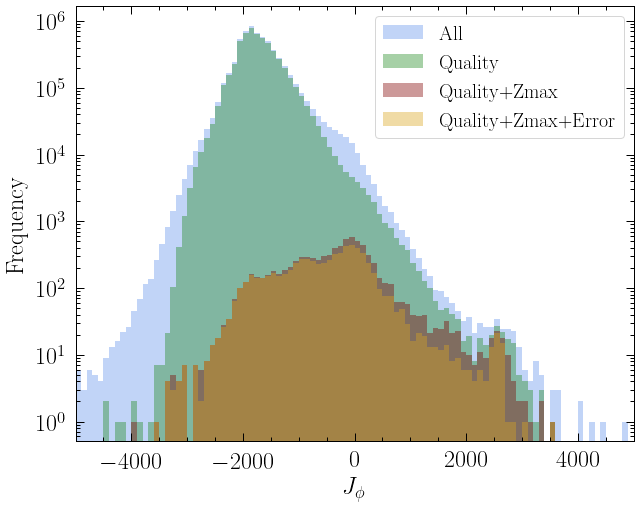

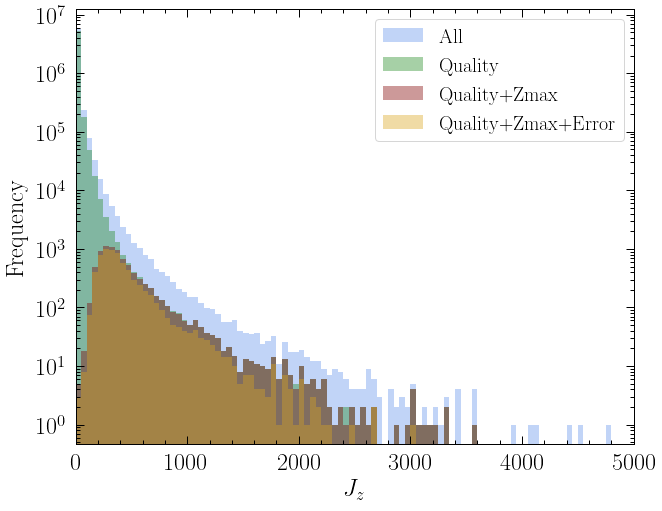

In [106]:
# Make sure the cuts are properly applied before running this script!
dir_plot = './actions_abs_err_cut/zmax_'+str(cutoff)+'_'
col_to_plot = ['e_JR', 'e_Jphi', 'e_Jz']
rel_col_to_plot = ['JR', 'Jphi', 'Jz']
axis_labels = [r'$\sigma_{J_{R}}$',r'$\sigma_{J_{\phi}}$',r'$\sigma_{J_{z}}$']
xrange_list = [[0,1000],[0,1000],[0,1000]]
xbins_list = [np.arange(0,1000,10),np.arange(0,1000,10),np.arange(0,1000,10)]
# Plot the absolute error distribution
for col, axis_label, xrange, xbins in zip(col_to_plot,axis_labels,xrange_list,xbins_list):
    plot_dist(data_list=[df_orb_all.loc[:,col],df_orb_all.loc[ind_cut_pre_err_zmax,col],df_orb_all.loc[ind_cut_pre_err,col],df_orb_all.loc[ind_cut,col]],
              label_list=['All','Quality','Quality+Zmax','Quality+Zmax+Error'],xlabel=axis_label,xrange=xrange,ylog=True,
              hist=True,kde=False,bins=xbins,fname=dir_plot+col+'_dist.pdf')
# Plot the relative error distribution
axis_labels = [r'$\sigma_{J_{R},rel}$',r'$\sigma_{J_{\phi},rel}$',r'$\sigma_{J_{z},rel}$']
for col, rel_col, axis_label in zip(col_to_plot,rel_col_to_plot,axis_labels):
    plot_dist(data_list=[abs(df_orb_all.loc[:,col]/df_orb_all.loc[:,rel_col]),
                         abs(df_orb_all.loc[ind_cut_pre_err_zmax,col]/df_orb_all.loc[ind_cut_pre_err_zmax,rel_col]),
                         abs(df_orb_all.loc[ind_cut_pre_err,col]/df_orb_all.loc[ind_cut_pre_err,rel_col]),
                         abs(df_orb_all.loc[ind_cut,col]/df_orb_all.loc[ind_cut,rel_col])],
              label_list=['All','Quality','Quality+Zmax','Quality+Zmax+Error'],xlabel=axis_label,xrange=[0,1],ylog=True,
              hist=True,kde=False,bins=np.arange(0,1,0.01),fname=dir_plot+col+'_rel_dist.pdf')
# Plot how the original inputs distribution changes as we make the cuts
col_to_plot = ['JR', 'Jphi', 'Jz']
axis_labels = [r'$J_{R}$',r'$J_{\phi}$',r'$J_{z}$']
xrange_list = [[0,5000],[-5000,5000],[0,5000]]
xbins_list = [np.arange(0,5000,50),np.arange(-5000,5000,100),np.arange(0,5000,50)]
for col, axis_label, xrange, xbins in zip(col_to_plot,axis_labels,xrange_list,xbins_list):
    plot_dist(data_list=[df_orb_all.loc[:,col],df_orb_all.loc[ind_cut_pre_err_zmax,col],df_orb_all.loc[ind_cut_pre_err,col],df_orb_all.loc[ind_cut,col]],
              label_list=['All','Quality','Quality+Zmax','Quality+Zmax+Error'],xlabel=axis_label,xrange=xrange,ylog=True,
              hist=True,kde=False,bins=xbins,fname=dir_plot+col+'_dist.pdf')

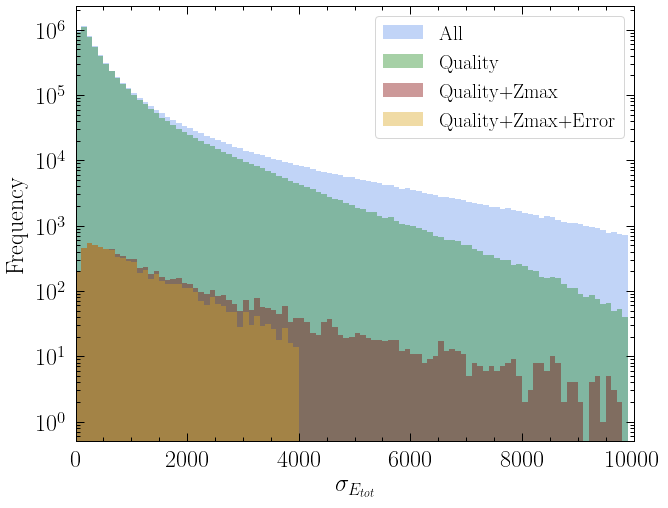

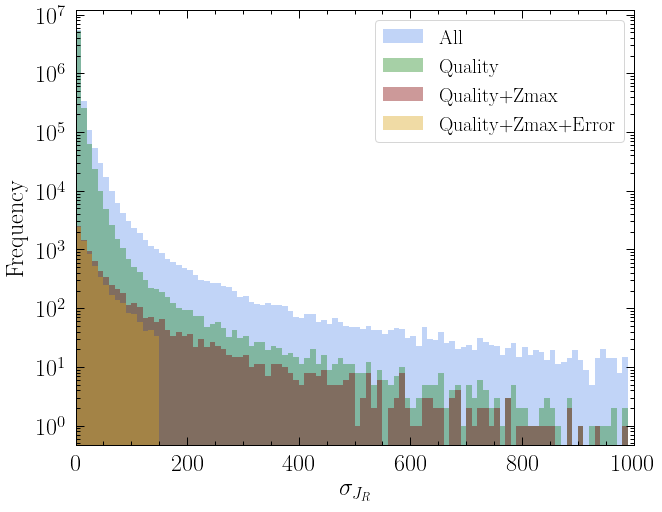

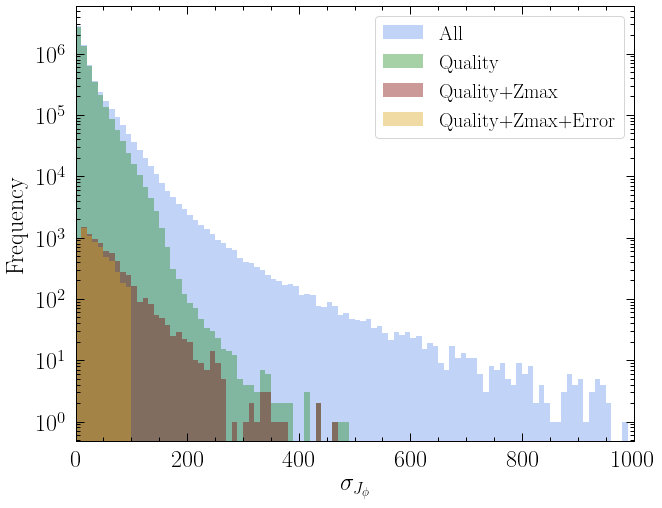

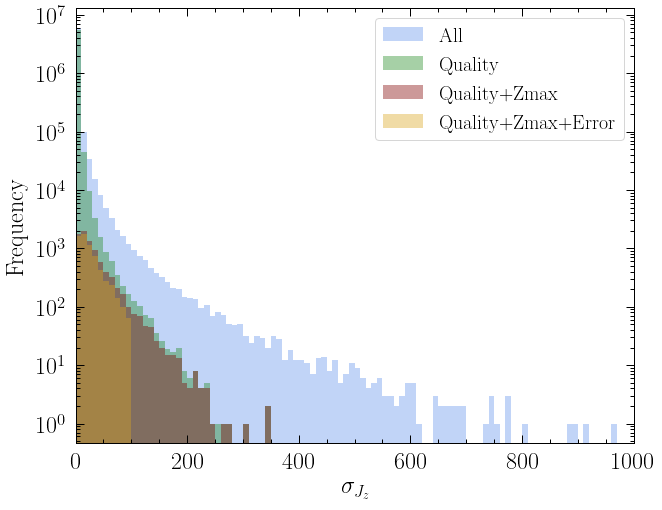

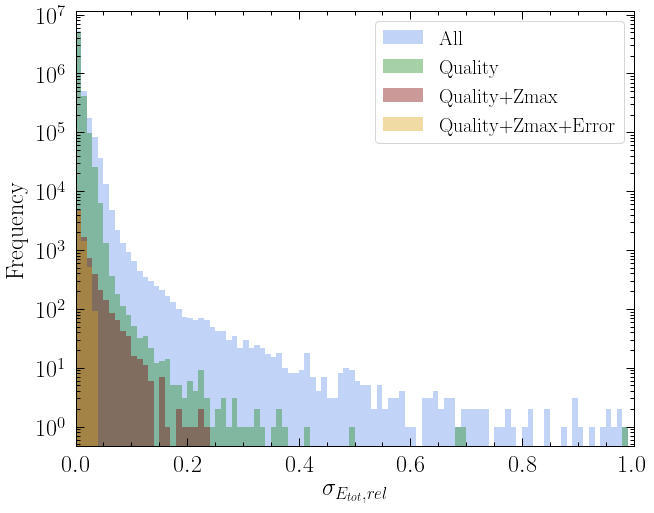

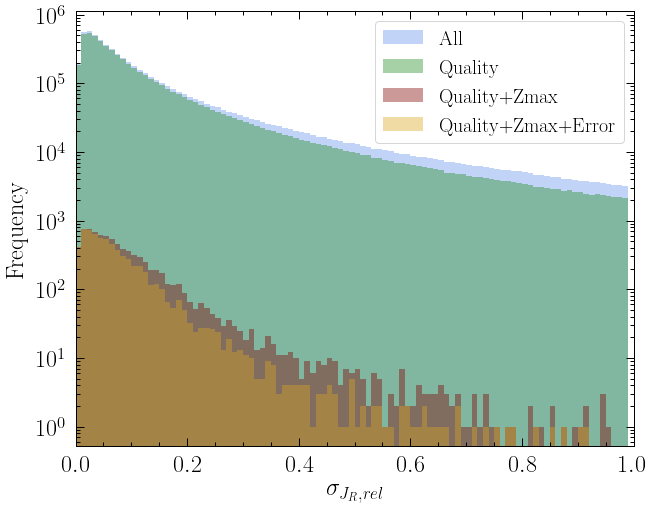

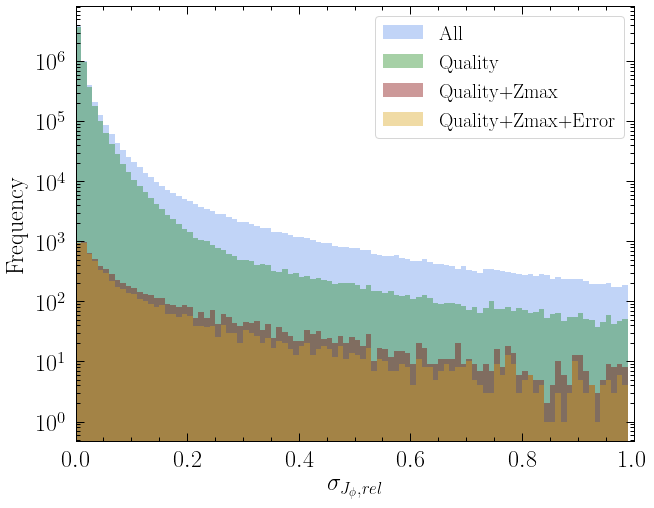

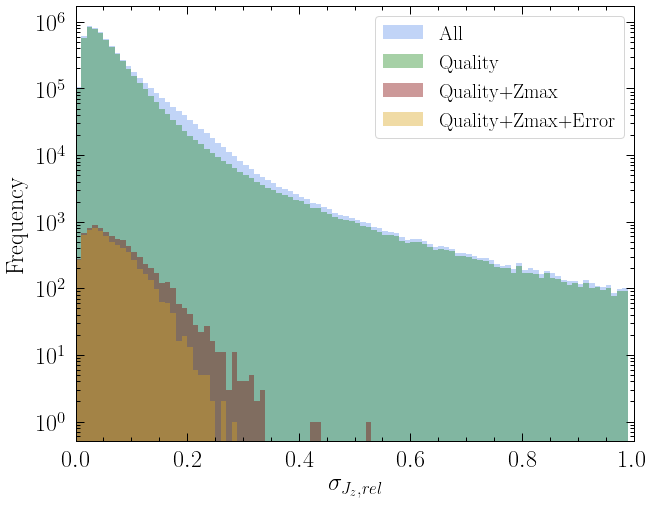

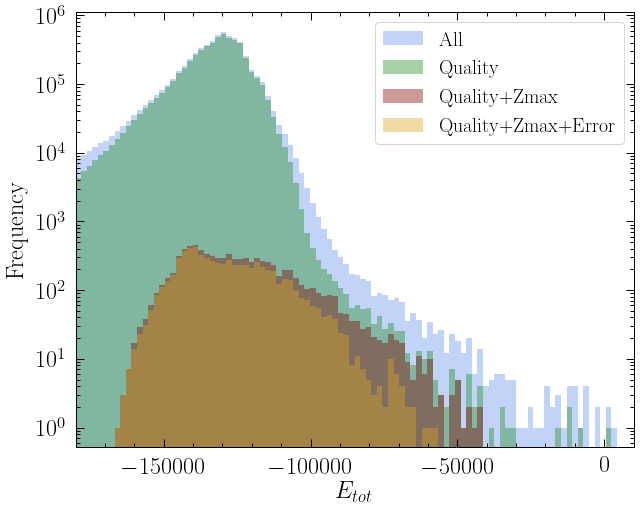

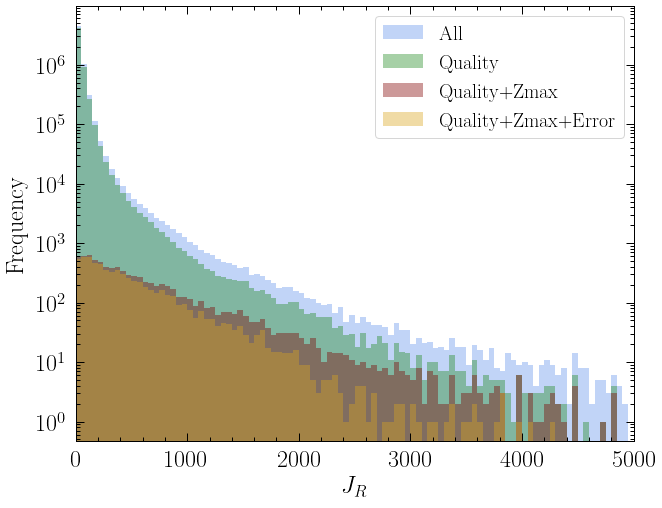

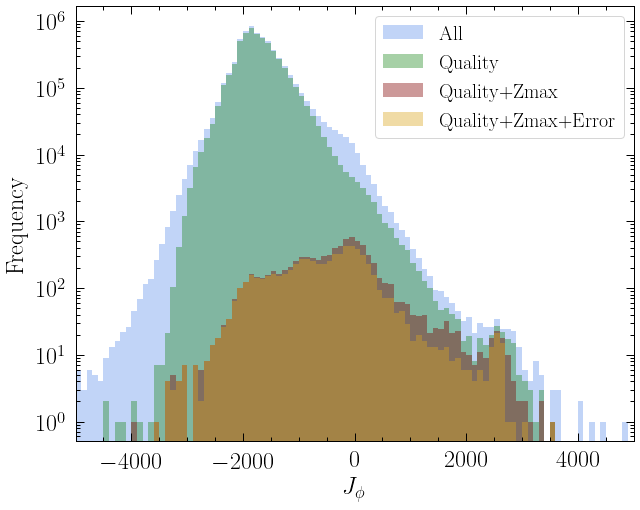

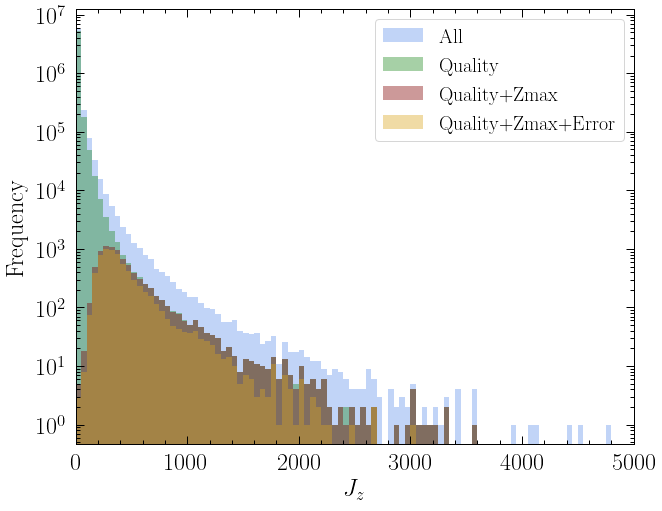

In [13]:
# Make sure the cuts are properly applied before running this script!
dir_plot = './energy_action_abs_err_cut/zmax_'+str(cutoff)+'_'
col_to_plot = ['e_Etot','e_JR', 'e_Jphi', 'e_Jz']
rel_col_to_plot = ['Etot','JR', 'Jphi', 'Jz']
axis_labels = [r'$\sigma_{E_{tot}}$',r'$\sigma_{J_{R}}$',r'$\sigma_{J_{\phi}}$',r'$\sigma_{J_{z}}$']
xrange_list = [[0,10000],[0,1000],[0,1000],[0,1000]]
xbins_list = [np.arange(0,10000,100),np.arange(0,1000,10),np.arange(0,1000,10),np.arange(0,1000,10)]
# Plot the absolute error distribution
for col, axis_label, xrange, xbins in zip(col_to_plot,axis_labels,xrange_list,xbins_list):
    plot_dist(data_list=[df_orb_all.loc[:,col],df_orb_all.loc[ind_cut_pre_err_zmax,col],df_orb_all.loc[ind_cut_pre_err,col],df_orb_all.loc[ind_cut,col]],
              label_list=['All','Quality','Quality+Zmax','Quality+Zmax+Error'],xlabel=axis_label,xrange=xrange,ylog=True,
              hist=True,kde=False,bins=xbins,fname=dir_plot+col+'_dist.pdf')
# Plot the relative error distribution
axis_labels = [r'$\sigma_{E_{tot},rel}$',r'$\sigma_{J_{R},rel}$',r'$\sigma_{J_{\phi},rel}$',r'$\sigma_{J_{z},rel}$']
for col, rel_col, axis_label in zip(col_to_plot,rel_col_to_plot,axis_labels):
    plot_dist(data_list=[abs(df_orb_all.loc[:,col]/df_orb_all.loc[:,rel_col]),
                         abs(df_orb_all.loc[ind_cut_pre_err_zmax,col]/df_orb_all.loc[ind_cut_pre_err_zmax,rel_col]),
                         abs(df_orb_all.loc[ind_cut_pre_err,col]/df_orb_all.loc[ind_cut_pre_err,rel_col]),
                         abs(df_orb_all.loc[ind_cut,col]/df_orb_all.loc[ind_cut,rel_col])],
              label_list=['All','Quality','Quality+Zmax','Quality+Zmax+Error'],xlabel=axis_label,xrange=[0,1],ylog=True,
              hist=True,kde=False,bins=np.arange(0,1,0.01),fname=dir_plot+col+'_rel_dist.pdf')
# Plot how the original inputs distribution changes as we make the cuts
col_to_plot = ['Etot','JR', 'Jphi', 'Jz']
axis_labels = [r'$E_{tot}$',r'$J_{R}$',r'$J_{\phi}$',r'$J_{z}$']
xrange_list = [[-180000,10000],[0,5000],[-5000,5000],[0,5000]]
xbins_list = [np.arange(-180000,10000,1900),np.arange(0,5000,50),np.arange(-5000,5000,100),np.arange(0,5000,50)]
for col, axis_label, xrange, xbins in zip(col_to_plot,axis_labels,xrange_list,xbins_list):
    plot_dist(data_list=[df_orb_all.loc[:,col],df_orb_all.loc[ind_cut_pre_err_zmax,col],df_orb_all.loc[ind_cut_pre_err,col],df_orb_all.loc[ind_cut,col]],
              label_list=['All','Quality','Quality+Zmax','Quality+Zmax+Error'],xlabel=axis_label,xrange=xrange,ylog=True,
              hist=True,kde=False,bins=xbins,fname=dir_plot+col+'_dist.pdf')

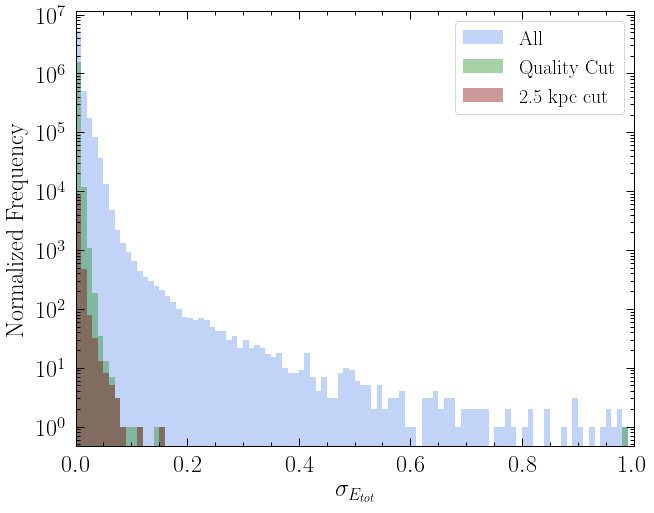

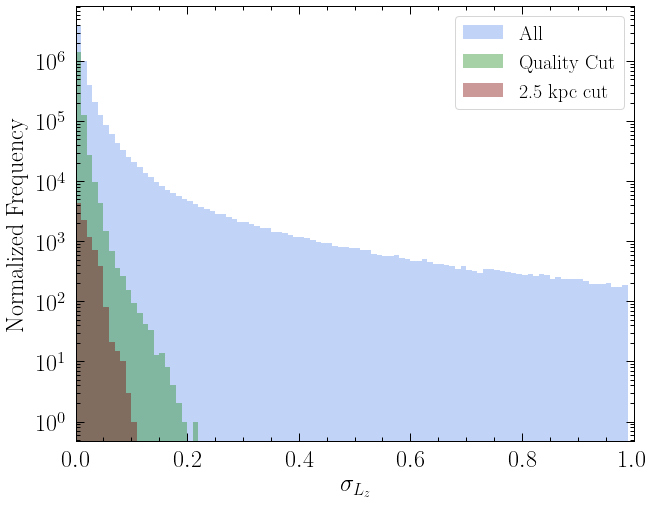

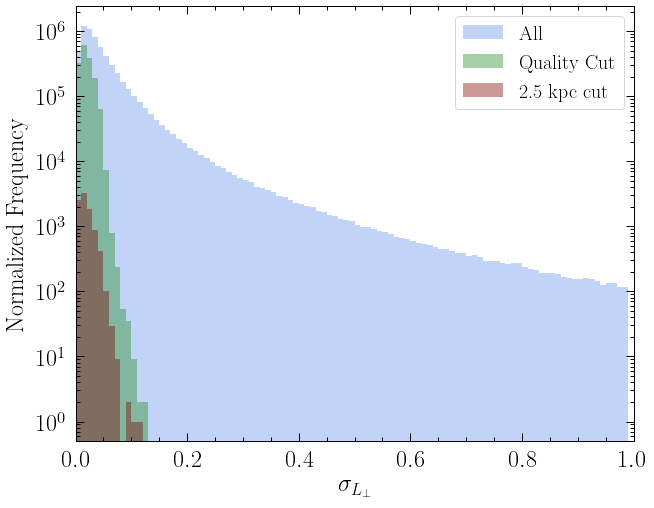

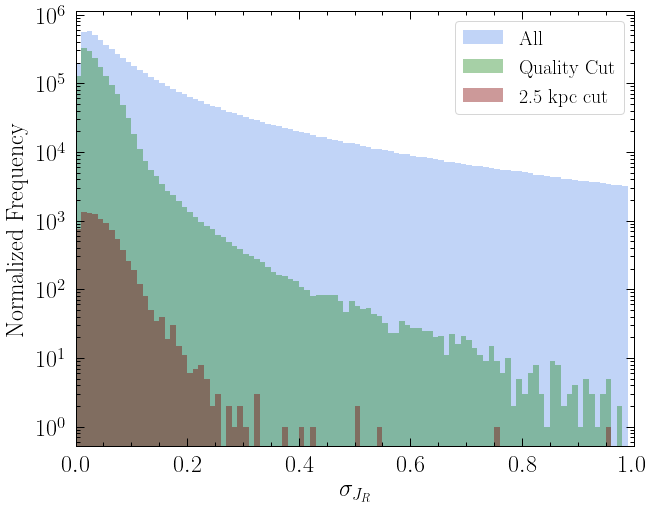

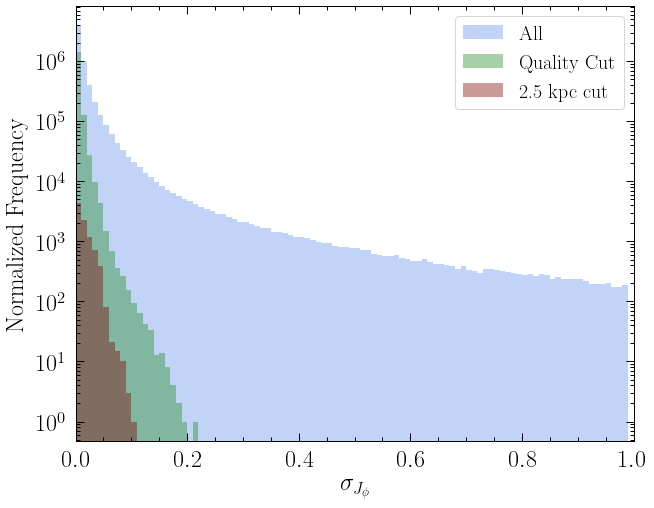

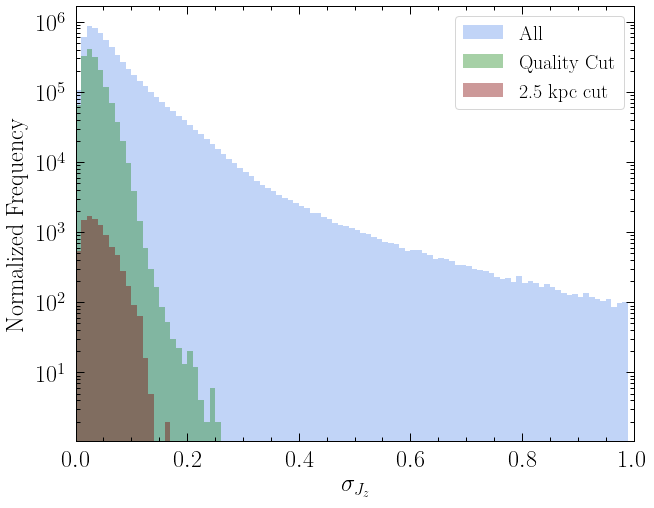

In [50]:
col_to_plot = ['e_Etot','e_Lz','e_Lperp', 'e_JR', 'e_Jphi', 'e_Jz']
rel_col_to_plot = ['Etot','Lz','Lperp', 'JR', 'Jphi', 'Jz']
axis_labels = [r'$\sigma_{E_{tot}}$',r'$\sigma_{L_{z}}$',r'$\sigma_{L_{\bot}}$',r'$\sigma_{J_{R}}$',r'$\sigma_{J_{\phi}}$',r'$\sigma_{J_{z}}$']
for col, rel_col, axis_label in zip(col_to_plot,rel_col_to_plot,axis_labels):
    plot_dist(data_list=[abs(df_orb_all[col]/df_orb_all[rel_col]),abs(df_orb_all.loc[kin_qual,col]/df_orb_all.loc[kin_qual,rel_col]),
                         abs(df_orb_all.loc[combined_cut,col]/df_orb_all.loc[combined_cut,rel_col])],
              label_list=['All','Quality Cut','2.5 kpc cut'],xlabel=axis_label,xrange=[0,1],ylog=True,
              hist=True,kde=False,bins=np.arange(0,1,0.01))